In [145]:
import glob
import pandas as pd
import datetime
import numpy.fft as fft
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
plot = False

# Preprocessing data.
Each file has a second of data in milliseconds (1000 measurements per file), the files aren't equally distributed in time we have big gaps between files, so we need to make some sort of preprocessing of the data before trying any anomaly detection algorithm.

In [146]:
def timestamper(timestamp):
    return datetime.datetime.fromtimestamp(float(timestamp)/1000)

## Reading raw data

In [147]:
files = glob.glob("data/raw/*.csv")

## FFT
Instead of using the data in the time domain we can transform it to the frequency domain and use each file as an example, then try to use clustering to identify at least 3 clusters (off, working, malfunctioning)

In [ ]:
count = 0
for i,file in enumerate(files):
    df = pd.read_csv(file,index_col="tiempo", parse_dates=True, date_parser=timestamper)
    df_fft = {}
    for column in df.columns:
        df_fft[column] = fft.rfft(df[column]).real
    df_fft = pd.DataFrame(df_fft)
    if plot:    
        freq_mean = df_fft.iloc[1:].abs().mean().mean()
        freq_std = df_fft.iloc[1:].std().mean()

        if  freq_mean > 1:
            if count < 10:
                count = count + 1
                print("File {}, filename: {}".format(i+1,file))

                fig,ax = plt.subplots(1,2, figsize=(20,5))
                df.plot(ax=ax[0], title="Tiempo")
                df_fft.plot(ax=ax[1], title="Fourier")
                plt.ylim([-300,300])
                plt.legend()
                plt.show()
                if freq_std < 12:
                    display(HTML("<h3>State: Normal</h3>"))
                else:
                    display(HTML("<h3>State: <b style='color:red;'>Anomaly?</b> </h3>"))


    if not plot:
        df_fft.to_csv(os.path.dirname(file).replace("raw", "fft/")+os.path.basename(file).replace(".csv", ".fft.csv"))
if plot:
    print("Count {}".format(count))

## Statistics
We can transform each file in a set of statistical values like mean an variance, this will give us a time series

In [132]:
df_results = []
for i,file in enumerate(files):
    df = pd.read_csv(file,index_col="tiempo", parse_dates=True, date_parser=timestamper)
    df_stats = {}
    for column in df.columns:
        df_stats[column+"-mean"] = df[column].mean()
        df_stats[column+"-std"] = df[column].std()
        df_stats[column+"-min"] = df[column].min()
        df_stats[column+"-max"] = df[column].max()
        df_stats[column+"-median"] = df[column].median()
        df_stats[column+"-kurt"] = df[column].kurt()
        df_stats[column+"-mad"] = df[column].mad()
        df_stats[column+"-var"] = df[column].var()

    df_stats["time"] = df.index[0]
    df_results.append(df_stats)

In [133]:
df_results = pd.DataFrame(df_results)

In [134]:
df_results.index = df_results.time
df_results = df_results.drop("time",axis=1)

In [135]:
df_results = df_results.sort_index()

In [136]:
df_results.to_csv("data/vibration_statistics.csv")

# Cleaning gaps
Looking into the time difference between files, we see files has a ~30 seconds gap between measurements, we need to extract the biggest segment that is continuous and get rid of the time gaps. 

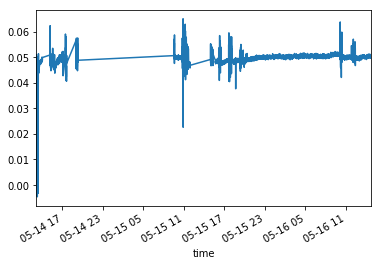

In [137]:
%matplotlib inline
df_results["X-mean"].plot()
plt.show()

In [138]:
df_filtered = df_results[df_results.index >= pd.to_datetime('2017-05-15 15:40')]
df_filtered.to_csv("data/filtered_statistics.csv")

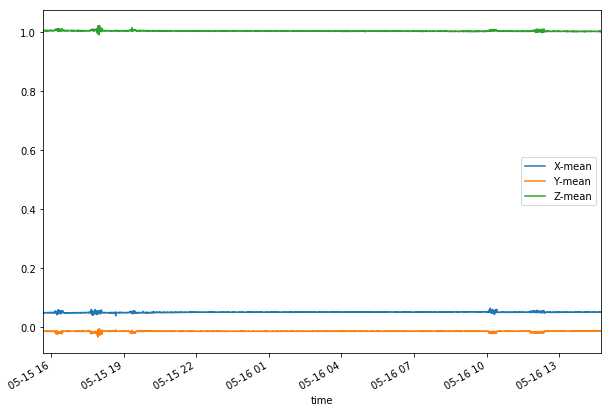

In [139]:
df_filtered[["X-mean","Y-mean","Z-mean"]].plot(figsize=(10,7))
plt.show()

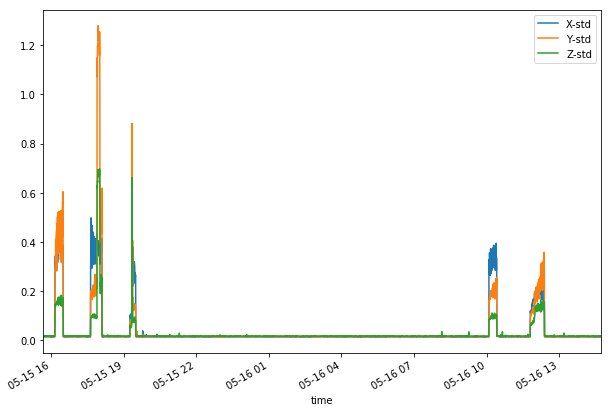

In [140]:
df_filtered[["X-std","Y-std","Z-std"]].plot(figsize=(10,7))
plt.show()